In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from ShapeDataset import *

In [2]:
# Specify the path to your "images" and "masks" directories
images_dir = './images'
masks_dir = './masks'

# Get a sorted list of file names in the "images" directory
images = sorted(os.listdir(images_dir))

# Get a sorted list of file names in the "masks" directory
masks = sorted(os.listdir(masks_dir))

In [3]:
idx = 0
img = Image.open(os.path.join(images_dir, images[idx])).convert("RGB")
mask = Image.open(os.path.join(masks_dir, masks[idx]))

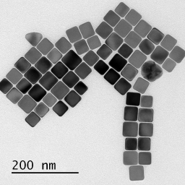

In [4]:
img

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]


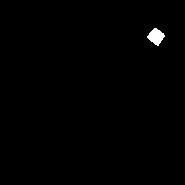

In [23]:
print(np.unique(mask))
Image.fromarray(np.array(mask) == 3)

In [9]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

In [10]:
transform = T.ToTensor()

In [11]:
def custom_collate(data):
  return data

In [12]:
images = sorted(os.listdir(images_dir))
masks = sorted(os.listdir(masks_dir))
num = int(0.9 * len(images))
num = num if num % 2 == 0 else num + 1
if (num - int(0.9 * len(images)) <= 1):
  num-=1
train_imgs_inds = np.random.choice(range(len(images)) , num , replace = False)

val_imgs_inds = np.setdiff1d(range(len(images)) , train_imgs_inds)
train_imgs = np.array(images)[train_imgs_inds]
val_imgs = np.array(images)[val_imgs_inds]
train_masks = np.array(masks)[train_imgs_inds]
val_masks = np.array(masks)[val_imgs_inds]

In [13]:
train_dl = torch.utils.data.DataLoader(ShapeDataset(train_imgs , train_masks) ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 0 ,
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(ShapeDataset(val_imgs , val_masks) ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 0 ,
                                 pin_memory = True if torch.cuda.is_available() else False)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'{device = }')
model.to(device)

device = device(type='cpu')


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [16]:
params = [p for p in model.parameters() if p.requires_grad]

In [17]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [18]:
all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(2):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i in range(len(train_dl)):
        dt = next(iter(train_dl))
        imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
        targ = [dt[0][1] , dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
      for j in range(len(val_dl)):
            dt = next(iter(val_dl))  # Get the next batch
            imgs = [dt[0][0].to(device), dt[1][0].to(device)]
            targ = [dt[0][1], dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
    all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

{'loss_classifier': tensor(0.6835, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4207, grad_fn=<DivBackward0>), 'loss_mask': tensor(1.6697, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6883, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1664, grad_fn=<DivBackward0>)}
0    12.45044994354248    2.273521900177002
1    7.457045912742615    2.1993489265441895


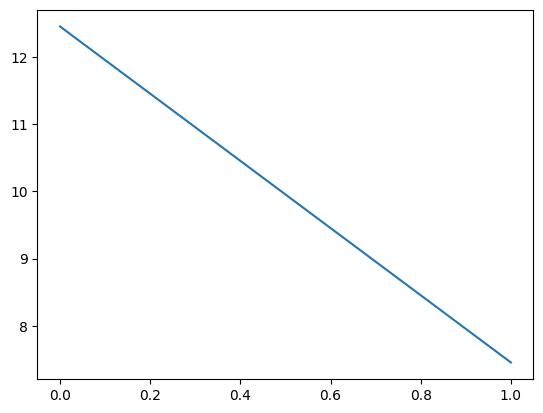

In [19]:
plt.plot(all_train_losses)

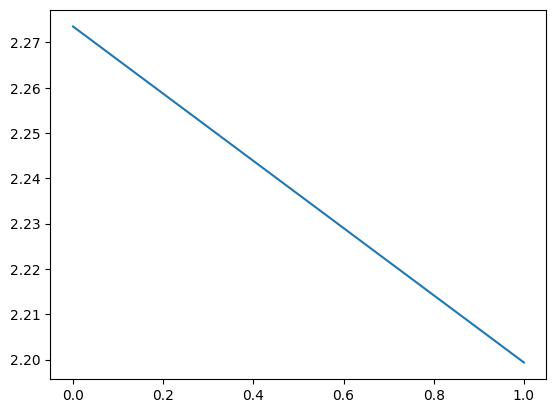

In [20]:
plt.plot(all_val_losses)

In [32]:
model.eval()
img = Image.open("./Picture184.png").convert("RGB")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

/Users/johannes/Documents/Uni/Semester7/MachineLearning/MLvenv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


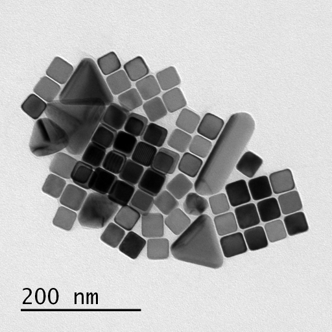

In [33]:
img

In [34]:
pred

[{'boxes': tensor([[2.8503e+02, 1.0577e+00, 3.3196e+02, 5.2761e+01],
          [4.5853e+01, 7.8397e-02, 9.8531e+01, 4.5827e+01],
          [1.7193e+02, 7.5309e-02, 2.2459e+02, 4.5729e+01],
          [8.5593e+01, 6.3053e-02, 1.3827e+02, 4.5746e+01],
          [0.0000e+00, 8.7474e+01, 4.4678e+01, 1.3959e+02],
          [0.0000e+00, 1.1609e+00, 5.1892e+01, 5.2691e+01],
          [1.1891e+02, 6.4074e-02, 1.7144e+02, 4.5798e+01],
          [1.3102e+01, 5.4688e+01, 6.4810e+01, 1.0636e+02],
          [1.7280e+02, 2.0777e+02, 2.2473e+02, 2.5970e+02],
          [1.3965e+02, 1.8837e+02, 1.9135e+02, 2.4003e+02],
          [1.9864e+02, 8.4545e-02, 2.5138e+02, 4.5767e+01],
          [1.9603e+01, 6.8823e+01, 7.1965e+01, 1.2027e+02],
          [1.2562e+01, 7.7898e+00, 6.4927e+01, 5.9456e+01],
          [1.3978e+02, 7.5070e+01, 1.9166e+02, 1.2664e+02],
          [0.0000e+00, 1.2707e+02, 4.4728e+01, 1.7931e+02],
          [6.6656e+01, 4.8504e+01, 1.1861e+02, 1.0016e+02],
          [2.6476e+01, 1.2165e+

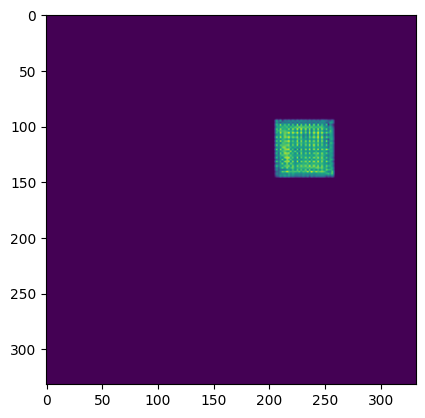

In [35]:
plt.imshow((pred[0]["masks"][25].cpu().detach().numpy() * 255).astype("uint8").squeeze())

In [36]:
from torchvision.transforms import v2 as T
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

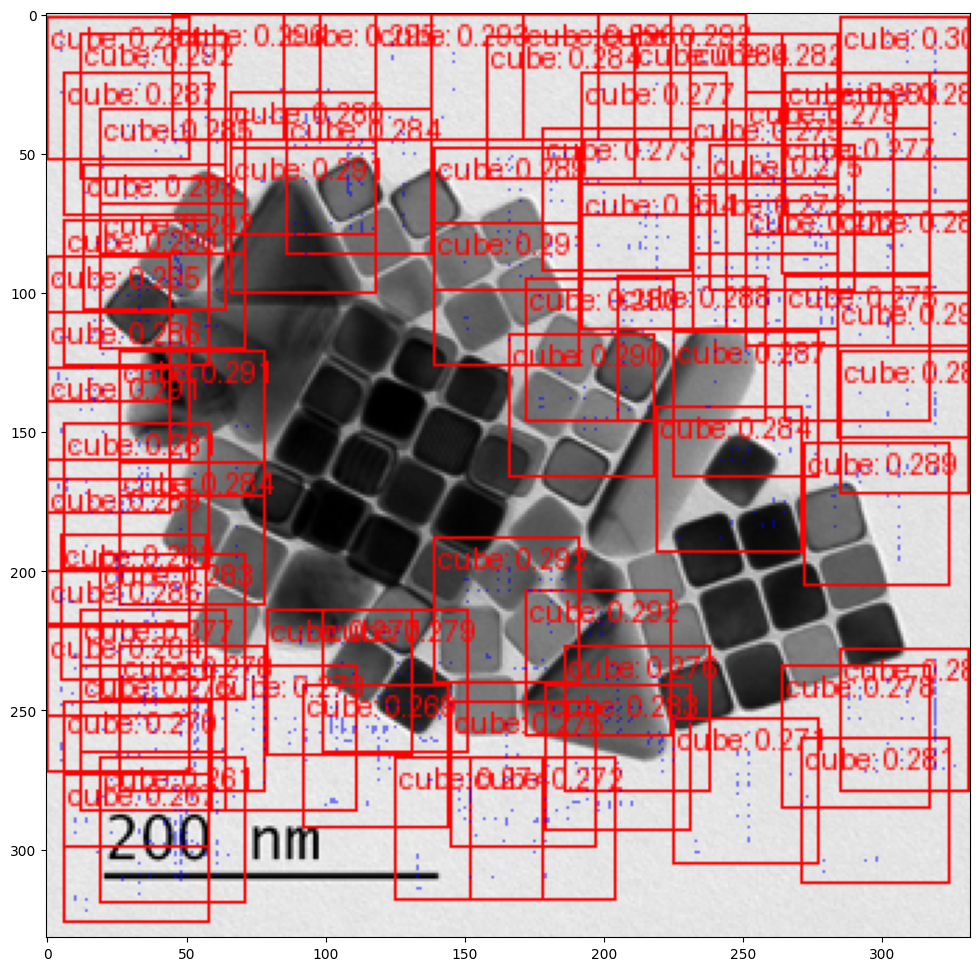

In [37]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("./Picture184.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"cube: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [38]:
img.size

(332, 332)

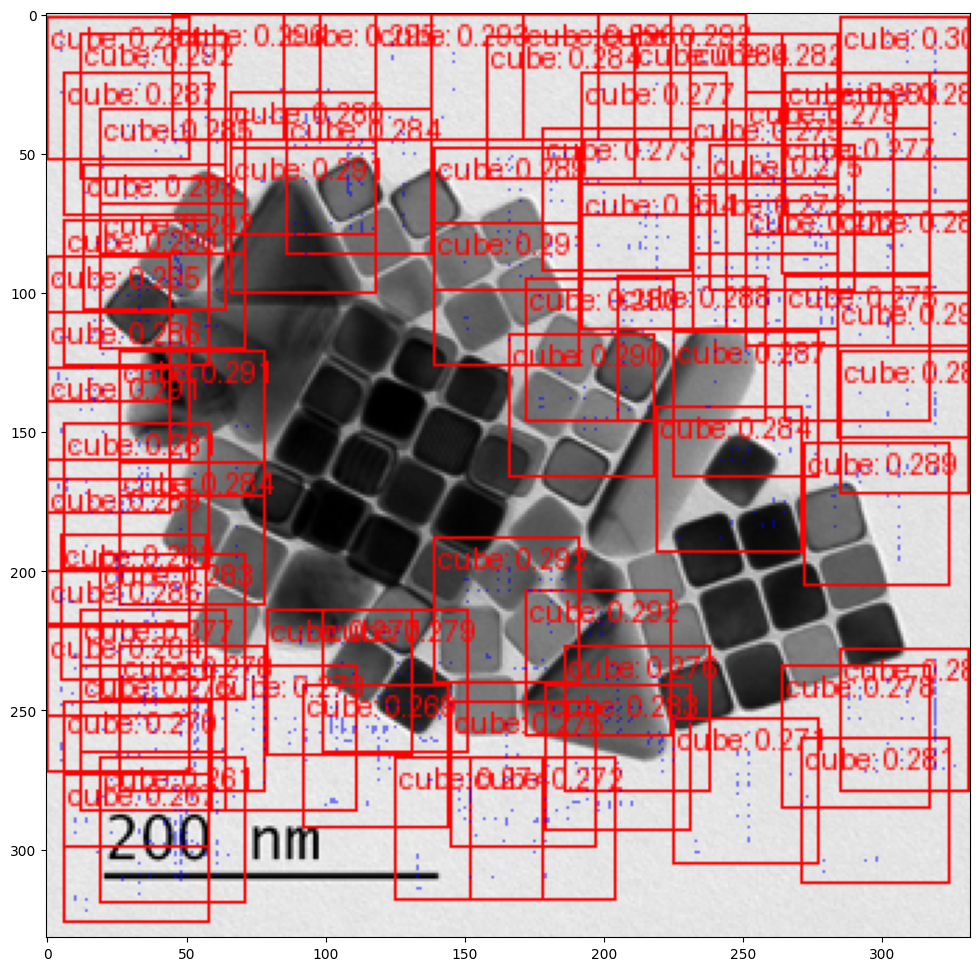

In [40]:
image = read_image("./Picture184.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"cube: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))